[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
import JaxSSO.optimization as optimization
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from jax import grad,value_and_grad

# Define the objective function and the gradient of the objective

*   Import the geometry, mesh
*   Build the FEA model
*   Build the SSO model



Import the data needed

In [6]:
#Import the geometry, mesh and fixed node info
local_path = 'https://raw.githubusercontent.com/GaoyuanWu/JaxSSO/main/data/Mannheim_Multihalle/' #path of the file
df = pd.read_csv(local_path + 'Mesh.csv') #Connectivity matrix
cnct = df.to_numpy() #convert to numpy array
df2 = pd.read_csv(local_path + 'Coordinate.csv') #Coordinate
crd = df2.to_numpy() #convert to numpy array
df3 = pd.read_csv(local_path + 'fixed_nodes.csv') #Connectivity matrix
fixed_nodes = df3.to_numpy().reshape(-1) #convert to numpy array

#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

URLError: <urlopen error [Errno -2] Name or service not known>

In [2]:
#Import the geometry, mesh and fixed node info
local_path = 'Data/Mannheim_Triangle/' #path of the file
df = pd.read_csv(local_path + 'Mesh.csv') #Connectivity matrix
cnct = df.to_numpy() #convert to numpy array
df2 = pd.read_csv(local_path + 'Coordinate.csv') #Coordinate
crd = df2.to_numpy() #convert to numpy array
df3 = pd.read_csv(local_path + 'fixed_nodes.csv') #Connectivity matrix
fixed_nodes = df3.to_numpy().reshape(-1) #convert to numpy array

#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

Configure the design variables and non-design variables

In [3]:
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
    design_nodes.append(i)
    z_nodes[i] = np.random.uniform(0.5,0.501)#random_z
  else:
    z_nodes[i] = 0
fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

design_crds = np.expand_dims(design_nodes,axis=1)
design_crds = np.hstack((design_crds,2*np.ones((design_crds.shape[0],1),dtype=int)))

The initial structure, visualization

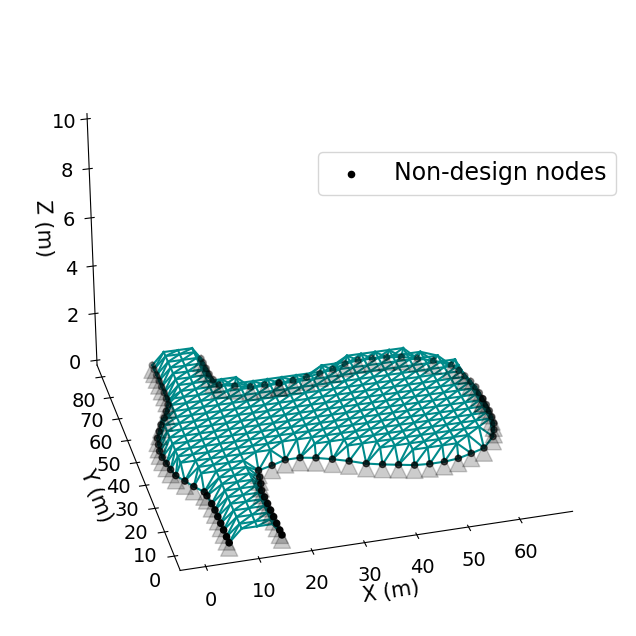

In [4]:

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

# Create FEA model

In [5]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)

#Adjustment of moment of inertia
a_I = 1e-10
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area
load = 50000 #Pt load

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    model.add_beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 


# SSO model based on FEA model

In [6]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

In [ ]:
%timeit sso_model.value_grad_params(which_solver='dense',enforce_scipy_sparse = True)

In [7]:
def objective(x,sso_model=sso_model):
    sso_model.update_nodeparameter(x) # Update the model
    C,sens = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    return C,sens #sens_params

In [8]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
opt = optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(200) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalized
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 737315.8250651914
Step 1, objective = 660242.9064528024
Step 2, objective = 580304.5857768947
Step 3, objective = 509336.32721611834
Step 4, objective = 447183.3510821848
Step 5, objective = 390106.2030060913
Step 6, objective = 338720.41327788564
Step 7, objective = 296077.44342634163
Step 8, objective = 257632.64006245736
Step 9, objective = 225236.79718050832
Step 10, objective = 199183.43257668376
Step 11, objective = 180084.14216319332
Step 12, objective = 168223.12234464276
Step 13, objective = 159357.36069496957
Step 14, objective = 151768.49519129843
Step 15, objective = 144428.9052596098
Step 16, objective = 137272.5957492977
Step 17, objective = 131882.7896640479
Step 18, objective = 127118.12339057244
Step 19, objective = 122275.73851030468
Step 20, objective = 116548.47380088805
Step 21, objective = 108323.32003321462
Step 22, objective = 99365.86131357774
Step 23, objective = 91173.69109317183
Step 24, objective = 83036.50314202055
Step 25, objective = 

# Draw the final structure

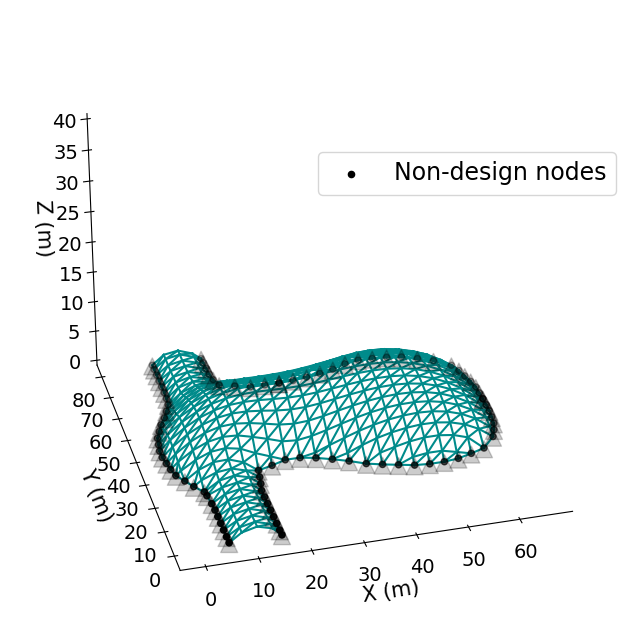

In [164]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,40)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(30, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

# Fix the geometry and conduct sizing optimization using GD

In [285]:
################
#  SSO MODEL   #
################
#Build the model
#Sectional properties-> 600x400 rectangle

model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):

    model.add_node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
        model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow
    else:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-load,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    #ai
    a_i = 1e-10
    model.add_beamcol(i,i_node,j_node,E,G,a_i*Iy,a_i*Iz,J,A) 


In [286]:
model.model_ready()
model.solve()
print(model.strain_energy())

15351.109630507677


In [287]:
np.max(model.u[design_nodes*6+2])

Array(0.05029924, dtype=float64)

In [288]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model
ele_Length = [] #calculate the length of every member
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 0,prop_type = 5) # element object
    sso_model.add_eleparameter(eleparameter)
    
    node_1 = np.array([x_ele[eletag,0],y_ele[eletag,0],z_ele[eletag,0]])
    node_2 = np.array([x_ele[eletag,1],y_ele[eletag,1],z_ele[eletag,1]])
    temp_length = np.linalg.norm(node_1-node_2)
    ele_Length.append(temp_length)

#Initial the parameters
sso_model.initialize_parameters_values()
ele_Length = np.array(ele_Length)

Define Objective Function

In [289]:
#W(A): total volume
def volume(A):
    '''
    Volume and penalty
    '''
    
    return ele_Length.T@A + 1*penalty(A)
def penalty(A):
    '''
    Limit the minimum area
    '''
    return jnp.sum(jnp.where(A<0.05,((0.05-A)/0.05),0))
    
#C(A): violation of displacement
def user_obj(sso_model,u,u_max):
    u_z = jnp.abs(u[design_nodes*6+2]) #Z-displacement
    n_uz = u_z/u_max-1 #normalize
    c = jnp.sum(jnp.where(n_uz>0,n_uz,0))
    return c
sso_model.set_objective(objective='user',func=user_obj,func_args=(0.1,))

In [290]:
volume(sso_model.parameter_values)

Array(958.84659576, dtype=float64)

In [291]:
penalty(sso_model.parameter_values)

Array(0., dtype=float64)

In [292]:
sso_model.params_to_objective()

Array(0., dtype=float64)

In [293]:
sso_model.value_grad_params()[1]

Array([0., 0., 0., ..., 0., 0., 0.], dtype=float64)

$$f(A)=(1+\epsilon_1c(A))^{\epsilon_2}W(A)$$
$$\frac{df}{dA} = \epsilon_1\epsilon_2(1+\epsilon_1c)^{\epsilon_2-1}\frac{\partial C}{\partial A}W(A)+ (1+\epsilon_1c)^{\epsilon_2} \frac{\partial W}{\partial A}$$

Engineering with Computers (2023) 39:2585–2608
A novel deep unsupervised learning‑based framework for optimization of truss structures
Hau T. Mai1,2 · Qui X. Lieu3,4 · Joowon Kang5 · Jaehong Lee1

In [294]:
eps1 = 1
eps2 = 1
i = 0
W_list = []#Storing the total weight
SE_list = []#Storing the strain energy
u_max_list = []#Storing the maximum displacement along Z

In [295]:
def objective(A,sso_model=sso_model):
    sso_model.update_eleparameter(A) # Update the model
    c,grad_c = sso_model.value_grad_params(which_solver='sparse',enforce_scipy_sparse = True)
    W,grad_W = value_and_grad(volume)(sso_model.parameter_values) #Volume/weight
    pen = penalty(sso_model.parameter_values) #Volume/weight
    W_list.append(W)
    SE_list.append(sso_model.params_c(sso_model.parameter_values,which_solver='sparse',enforce_scipy_sparse = True))
    u_max = np.max(np.abs(sso_model.params_u(sso_model.parameter_values,which_solver='sparse',enforce_scipy_sparse = True))[design_nodes*6+2])
    u_max_list.append(u_max)
    #p,grad_p = 
    kappa = 1+0.02#1/n_node #learning parameter of eps1
    global i,eps1
    if c>0 or pen>0:
        eps1 = (1/kappa)*eps1
    else:
        eps1 = (kappa)*eps1
    print(eps1)
    i+=1
    obj = (1+eps1*c)**eps2 * W 
    
    sens = eps2*(1+eps1*c)**(eps2-1)*grad_c*W + (1+eps1*c)**(eps2)*grad_W
    return obj,sens #sens_params

In [296]:
n_A = sso_model.parameter_values.shape[0] #number of parameters
A_ini = sso_model.parameter_values #initial parameters 
opt = optimization.Optimization(n_A,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(4000) #max iteration
opt.set_step_size(5e-4) #step size
opt.set_GD_normalized(True) #normalized
A_opt = opt.optimize(A_ini,log=True)

1.05
Step 0, objective = 958.8465957590917
1.1025
Step 1, objective = 957.5642340932945
1.1576250000000001
Step 2, objective = 956.2818724274973
1.2155062500000002
Step 3, objective = 954.9995107617002
1.2762815625000004
Step 4, objective = 953.717149095903
1.3400956406250004
Step 5, objective = 952.4347874301059
1.4071004226562505
Step 6, objective = 951.1524257643088
1.477455443789063
Step 7, objective = 949.8700640985114
1.5513282159785162
Step 8, objective = 948.5877024327144
1.628894626777442
Step 9, objective = 947.3053407669172
1.7103393581163142
Step 10, objective = 946.02297910112
1.79585632602213
Step 11, objective = 944.7406174353227
1.8856491423232367
Step 12, objective = 943.4582557695255
1.9799315994393987
Step 13, objective = 942.1758941037285
2.0789281794113688
Step 14, objective = 940.8935324379312
2.1828745883819374
Step 15, objective = 939.6111707721341
2.2920183178010345
Step 16, objective = 938.3288091063368
2.406619233691086
Step 17, objective = 937.0464474405399


84.76688330158314
Step 144, objective = 832.2535284839955
89.00522746666229
Step 145, objective = 807.5237515678524
84.76688330158314
Step 146, objective = 861.9025669757166
89.00522746666229
Step 147, objective = 806.2412727826247
84.76688330158314
Step 148, objective = 891.404327497133
80.73036504912679
Step 149, objective = 807.3183129194507
84.76688330158314
Step 150, objective = 804.9589170658936
80.73036504912679
Step 151, objective = 835.1420327717811
84.76688330158314
Step 152, objective = 803.6766987313312
80.73036504912679
Step 153, objective = 862.8223500413743
84.76688330158314
Step 154, objective = 802.394119996981
80.73036504912679
Step 155, objective = 890.3583241525346
76.88606195154932
Step 156, objective = 809.8433405019354
80.73036504912679
Step 157, objective = 801.1115718881
76.88606195154932
Step 158, objective = 835.8026331549552
80.73036504912679
Step 159, objective = 799.8292603561069
76.88606195154932
Step 160, objective = 861.6214837439372
80.73036504912679
S

35.2223908605493
Step 286, objective = 740.8517378159765
36.983510403576766
Step 287, objective = 727.9891001855078
35.2223908605493
Step 288, objective = 746.9403334925879
36.983510403576766
Step 289, objective = 726.7060222093064
35.2223908605493
Step 290, objective = 752.9234421601354
36.983510403576766
Step 291, objective = 725.4227996109679
35.2223908605493
Step 292, objective = 758.8000491300434
36.983510403576766
Step 293, objective = 724.1394327067767
35.2223908605493
Step 294, objective = 764.5691997273021
33.54513415290409
Step 295, objective = 727.6065745955401
35.2223908605493
Step 296, objective = 722.8554016132988
33.54513415290409
Step 297, objective = 732.9108833071757
35.2223908605493
Step 298, objective = 721.5723854289672
33.54513415290409
Step 299, objective = 738.1104066108347
35.2223908605493
Step 300, objective = 720.2892353733812
33.54513415290409
Step 301, objective = 743.2040260681595
35.2223908605493
Step 302, objective = 719.0059518980993
33.54513415290409
S

28.97754812906086
Step 428, objective = 640.6764349875624
27.597664884819867
Step 429, objective = 645.8955330913371
28.97754812906086
Step 430, objective = 639.3918620107056
27.597664884819867
Step 431, objective = 644.9215778336348
28.97754812906086
Step 432, objective = 638.1072763865752
27.597664884819867
Step 433, objective = 644.1163633184509
28.97754812906086
Step 434, objective = 636.8226750988417
27.597664884819867
Step 435, objective = 643.4741077285894
28.97754812906086
Step 436, objective = 635.538055343138
27.597664884819867
Step 437, objective = 642.9891389873376
28.97754812906086
Step 438, objective = 634.2534145203318
27.597664884819867
Step 439, objective = 642.6557359264584
28.97754812906086
Step 440, objective = 632.9687502331814
27.597664884819867
Step 441, objective = 642.4681958990695
28.97754812906086
Step 442, objective = 631.6840602815369
27.597664884819867
Step 443, objective = 642.4207846912792
28.97754812906086
Step 444, objective = 630.3993426585365
27.5976

14.635630916373882
Step 570, objective = 562.5292261151492
13.938696110832268
Step 571, objective = 555.0874551245273
13.274948676983112
Step 572, objective = 562.9709567145818
12.64280826379344
Step 573, objective = 554.6685526411209
12.04076977504137
Step 574, objective = 563.1884541456193
11.467399785753686
Step 575, objective = 554.249643400955
10.921333129289225
Step 576, objective = 563.2159622301953
10.401269646942119
Step 577, objective = 553.830729172643
9.905971092325826
Step 578, objective = 563.0832657505072
9.434258183167453
Step 579, objective = 553.6143094615484
8.985007793492812
Step 580, objective = 553.4197609057708
8.557150279516964
Step 581, objective = 554.2163529343558
8.149666932873298
Step 582, objective = 553.0009140918623
7.761587555117426
Step 583, objective = 554.6268770603874
7.391988147730881
Step 584, objective = 552.5820589387454
7.039988712124648
Step 585, objective = 554.8726709407135
6.704751154404427
Step 586, objective = 552.1631969600057
6.38547728

0.01580918854663104
Step 710, objective = 527.9311953715935
0.015056370044410515
Step 711, objective = 527.5157895478784
0.014339400042295728
Step 712, objective = 527.512283984062
0.013656571468853074
Step 713, objective = 527.0979175194454
0.01300625854176483
Step 714, objective = 527.0933725320075
0.012386912896918886
Step 715, objective = 526.6797530889809
0.01179705990182751
Step 716, objective = 526.6753456049125
0.011235295144597628
Step 717, objective = 526.6823299247933
0.010700281090092979
Step 718, objective = 526.2580307014268
0.010190743895326647
Step 719, objective = 526.2634126490768
0.009705470376501567
Step 720, objective = 525.8404096458142
0.009243305120477682
Step 721, objective = 525.844495367386
0.008803147733788269
Step 722, objective = 525.422525555717
0.008383950222655494
Step 723, objective = 525.4255780825146
0.007984714497767137
Step 724, objective = 525.0044161682489
0.007604489997873463
Step 725, objective = 525.0066607969169
0.007242371426546155
Step 726,

2.2884609373617338e-05
Step 844, objective = 502.03575923471095
2.179486607011175e-05
Step 845, objective = 501.60899957014425
2.0757015304868333e-05
Step 846, objective = 501.6168140564716
1.9768586004636507e-05
Step 847, objective = 501.62464402723054
1.8827224766320483e-05
Step 848, objective = 501.19786436551715
1.7930690253638555e-05
Step 849, objective = 501.20569158523426
1.7076847860608145e-05
Step 850, objective = 500.77891456014805
1.6263664629150614e-05
Step 851, objective = 500.7867396683381
1.548920440871487e-05
Step 852, objective = 500.3599647318825
1.4751623246395112e-05
Step 853, objective = 500.3677882774872
1.4049164996566772e-05
Step 854, objective = 499.9410149608459
1.3380157139587401e-05
Step 855, objective = 499.9488374135957
1.2743006799607049e-05
Step 856, objective = 499.5220653172751
1.2136196952006713e-05
Step 857, objective = 499.52988749889226
1.1558282811434964e-05
Step 858, objective = 499.53771846057566
1.1007888391842822e-05
Step 859, objective = 499.

3.652212398275555e-08
Step 976, objective = 476.55785818259983
3.4782975221671947e-08
Step 977, objective = 476.56569256235423
3.3126643068258995e-08
Step 978, objective = 476.13890643519017
3.154918387453238e-08
Step 979, objective = 476.1467417087761
3.004684178526893e-08
Step 980, objective = 476.15457307977215
2.8616039795494217e-08
Step 981, objective = 475.727786918563
2.7253371233804015e-08
Step 982, objective = 475.7356191965671
2.5955591651241916e-08
Step 983, objective = 475.30883303996956
2.471961109642087e-08
Step 984, objective = 475.31666622764783
2.3542486758496067e-08
Step 985, objective = 474.8898800747005
2.2421415960472443e-08
Step 986, objective = 474.89771417459303
2.135372948616423e-08
Step 987, objective = 474.47092802447384
2.0336885224918315e-08
Step 988, objective = 474.4787630389719
1.9368462118969824e-08
Step 989, objective = 474.05197689098026
1.844615439901888e-08
Step 990, objective = 474.0598128238376
1.7567766094303692e-08
Step 991, objective = 474.0676

6.426095084580505e-11
Step 1106, objective = 452.01083849992415
6.120090556743338e-11
Step 1107, objective = 451.5852917015618
5.828657673088893e-11
Step 1108, objective = 451.59314212542307
5.551102545798945e-11
Step 1109, objective = 451.16993587224977
5.286764329332328e-11
Step 1110, objective = 451.177709969764
5.035013646983169e-11
Step 1111, objective = 450.75381803808574
4.795251092364923e-11
Step 1112, objective = 450.7616707455827
4.566905802252307e-11
Step 1113, objective = 450.33762810583767
4.349434097383149e-11
Step 1114, objective = 450.34540061814084
4.142318187983951e-11
Step 1115, objective = 450.3531712216685
3.945064940937096e-11
Step 1116, objective = 449.92711235765466
3.7572047056543764e-11
Step 1117, objective = 449.93496310704285
3.578290195861311e-11
Step 1118, objective = 449.5126423429726
3.40789542462982e-11
Step 1119, objective = 449.5204183367845
3.245614690123638e-11
Step 1120, objective = 449.0956506269734
3.09106160964156e-11
Step 1121, objective = 449.

1.1306762458713422e-13
Step 1236, objective = 427.1287173002472
1.0768345198774687e-13
Step 1237, objective = 426.7086452625567
1.0255566855975892e-13
Step 1238, objective = 426.7164229574474
9.767206529500848e-14
Step 1239, objective = 426.29221577672973
9.302101456667475e-14
Step 1240, objective = 426.3000931204533
8.859144244445213e-14
Step 1241, objective = 425.8733069475369
8.437280232804965e-14
Step 1242, objective = 425.88118550948946
8.035504983623776e-14
Step 1243, objective = 425.4588410677448
7.652861889165501e-14
Step 1244, objective = 425.4666586352837
7.288439894443334e-14
Step 1245, objective = 425.0462603283922
6.94137132804127e-14
Step 1246, objective = 425.0540429403337
6.61082983622978e-14
Step 1247, objective = 424.62931863233337
6.296028415456933e-14
Step 1248, objective = 424.63720072644526
5.996217538530412e-14
Step 1249, objective = 424.64507812875996
5.710683370028964e-14
Step 1250, objective = 424.21844882773195
5.438746066694251e-14
Step 1251, objective = 424

2.088904994337206e-16
Step 1365, objective = 414.6488765405337
1.989433327940196e-16
Step 1366, objective = 414.6567379671506
1.8946984075620914e-16
Step 1367, objective = 414.64827743405345
1.8044746738686585e-16
Step 1368, objective = 414.656137699673
1.7185473084463414e-16
Step 1369, objective = 414.23439735727754
1.636711722329849e-16
Step 1370, objective = 414.24214573000063
1.5587730688855704e-16
Step 1371, objective = 414.2336684773497
1.4845457798910194e-16
Step 1372, objective = 414.24141570201306
1.4138531237057326e-16
Step 1373, objective = 413.8195678303553
1.34652678448165e-16
Step 1374, objective = 413.8274292205051
1.282406461411095e-16
Step 1375, objective = 413.81896706235506
1.2213394870581857e-16
Step 1376, objective = 413.826827289108
1.1631804638649386e-16
Step 1377, objective = 413.4011110981758
1.1077909179666081e-16
Step 1378, objective = 413.4089339288531
1.0550389694920076e-16
Step 1379, objective = 413.40047538595803
1.0047990185638168e-16
Step 1380, objectiv

3.67544399186753e-19
Step 1495, objective = 405.08623512963476
3.5004228493976475e-19
Step 1496, objective = 404.6683286267946
3.3337360470453784e-19
Step 1497, objective = 404.67643861874126
3.174986711471789e-19
Step 1498, objective = 404.66780093310064
3.0237968680683703e-19
Step 1499, objective = 404.67591000468997
2.8798065410174955e-19
Step 1500, objective = 404.2546544991877
2.7426728962071385e-19
Step 1501, objective = 404.2624953290925
2.612069424959179e-19
Step 1502, objective = 404.2540064510778
2.4876851666277894e-19
Step 1503, objective = 404.2618461639807
2.3692239682169422e-19
Step 1504, objective = 403.8378521457989
2.2564037792542308e-19
Step 1505, objective = 403.84565569592087
2.1489559802421244e-19
Step 1506, objective = 403.8384304594172
2.0466247430877374e-19
Step 1507, objective = 403.8462318179687
1.9491664219883211e-19
Step 1508, objective = 403.42022701342086
1.8563489733222105e-19
Step 1509, objective = 403.42802852220905
1.7679514031640098e-19
Step 1510, obj

6.466971247604015e-22
Step 1625, objective = 395.59760017818064
6.159020235813347e-22
Step 1626, objective = 395.6053909194238
5.865733557917473e-22
Step 1627, objective = 395.18494597854095
5.586412912302355e-22
Step 1628, objective = 395.19258834620456
5.320393249811766e-22
Step 1629, objective = 395.18524899615176
5.067041190296919e-22
Step 1630, objective = 395.19288925038177
4.8257535145684945e-22
Step 1631, objective = 394.78148725426763
4.595955728160471e-22
Step 1632, objective = 394.78960763467586
4.377100693486163e-22
Step 1633, objective = 394.78242769827017
4.1686673271296786e-22
Step 1634, objective = 394.79054624757345
3.9701593591711223e-22
Step 1635, objective = 394.3716303635536
3.7811041515915447e-22
Step 1636, objective = 394.3792911178675
3.601051572944328e-22
Step 1637, objective = 394.3869523397726
3.4295729266136455e-22
Step 1638, objective = 394.37838396029997
3.2662599301082337e-22
Step 1639, objective = 394.3860441071959
3.1107237429602223e-22
Step 1640, objec

1.1378684373880755e-24
Step 1755, objective = 387.0759005127287
1.0836842260838814e-24
Step 1756, objective = 386.663783903632
1.0320802153179823e-24
Step 1757, objective = 386.6751653730569
9.829335383980783e-25
Step 1758, objective = 386.6831468379346
9.361271794267413e-25
Step 1759, objective = 386.67454683409073
8.915496946921345e-25
Step 1760, objective = 386.682527451584
8.490949473258423e-25
Step 1761, objective = 386.6739263910763
8.086618545960402e-25
Step 1762, objective = 386.68190616185456
7.7015414723432395e-25
Step 1763, objective = 386.6733040470473
7.334801402231657e-25
Step 1764, objective = 386.2575736946796
6.98552514498253e-25
Step 1765, objective = 386.2688020388844
6.652881090459552e-25
Step 1766, objective = 386.2767173859495
6.336077229009097e-25
Step 1767, objective = 386.26803831736714
6.034359265722949e-25
Step 1768, objective = 386.27595280985895
5.747008824498046e-25
Step 1769, objective = 386.2672725737255
5.473341737617187e-25
Step 1770, objective = 386.2

2.102192444953057e-27
Step 1884, objective = 379.1021479434139
2.002088042812435e-27
Step 1885, objective = 379.11000493931107
1.9067505169642237e-27
Step 1886, objective = 379.101204003928
1.8159528732992607e-27
Step 1887, objective = 378.69970037514565
1.7294789269516766e-27
Step 1888, objective = 378.7093834173438
1.6471227875730253e-27
Step 1889, objective = 378.71944496329996
1.5686883691171668e-27
Step 1890, objective = 378.71086177397103
1.4939889229687302e-27
Step 1891, objective = 378.71835905795444
1.4228465933035525e-27
Step 1892, objective = 378.7097748851459
1.355091993622431e-27
Step 1893, objective = 378.7172712139484
1.290563803449934e-27
Step 1894, objective = 378.7086860597198
1.2291083842380323e-27
Step 1895, objective = 378.7161814341854
1.1705794135600307e-27
Step 1896, objective = 378.707595300588
1.1148375367238386e-27
Step 1897, objective = 378.30676763154537
1.0617500349750843e-27
Step 1898, objective = 378.31680737814304
1.0111905095000802e-27
Step 1899, objec

3.6988233608027674e-30
Step 2014, objective = 371.6746360406925
3.5226889150502546e-30
Step 2015, objective = 371.68508067138595
3.354941823857385e-30
Step 2016, objective = 371.67641918075395
3.1951826893879855e-30
Step 2017, objective = 371.68388574538506
3.043031132750462e-30
Step 2018, objective = 371.28927496263555
2.8981248883337733e-30
Step 2019, objective = 371.2986751322067
2.76011894127026e-30
Step 2020, objective = 371.2911711012101
2.6286847059716763e-30
Step 2021, objective = 371.2987968174298
2.5035092437825487e-30
Step 2022, objective = 370.89985020361877
2.3842945178881415e-30
Step 2023, objective = 370.9096063962639
2.2707566837029917e-30
Step 2024, objective = 370.90202399942757
2.162625413050468e-30
Step 2025, objective = 370.9098407694077
2.0596432505242552e-30
Step 2026, objective = 370.9177016631687
1.9615650004992906e-30
Step 2027, objective = 370.90890159734033
1.8681571433326574e-30
Step 2028, objective = 370.51427754565975
1.7791972793644357e-30
Step 2029, obj

6.50810742245141e-33
Step 2144, objective = 365.232618268012
6.198197545191819e-33
Step 2145, objective = 365.2237428368305
5.903045281135065e-33
Step 2146, objective = 365.23119271867574
5.6219478867952996e-33
Step 2147, objective = 364.8532116892074
5.35423608266219e-33
Step 2148, objective = 364.8621129815706
5.099272459678276e-33
Step 2149, objective = 364.85455193830876
4.856449961598358e-33
Step 2150, objective = 364.8618358792242
4.6251904396174836e-33
Step 2151, objective = 364.85303896624765
4.4049432758261744e-33
Step 2152, objective = 364.8603864457823
4.195184072215404e-33
Step 2153, objective = 364.4829908130007
3.995413402109908e-33
Step 2154, objective = 364.49101406535453
3.805155621057055e-33
Step 2155, objective = 364.4832501363603
3.6239577343400525e-33
Step 2156, objective = 364.4909881041829
3.451388318419098e-33
Step 2157, objective = 364.1089830241011
3.287036493732474e-33
Step 2158, objective = 364.11623519896
3.13051094641188e-33
Step 2159, objective = 364.1073

1.1451063781800771e-35
Step 2274, objective = 358.94245359841614
1.0905775030286448e-35
Step 2275, objective = 358.94939248299477
1.0386452409796617e-35
Step 2276, objective = 358.9405605987265
9.891859437901539e-36
Step 2277, objective = 358.9475098248332
9.42081851228718e-36
Step 2278, objective = 358.93867862556664
8.97220810694017e-36
Step 2279, objective = 358.9456221835733
8.544960101847781e-36
Step 2280, objective = 358.9367893963754
8.13805723985503e-36
Step 2281, objective = 358.9437432649698
7.750530704623838e-36
Step 2282, objective = 358.598670518111
7.381457813927464e-36
Step 2283, objective = 358.6074467271068
7.029959822788061e-36
Step 2284, objective = 358.59939203081194
6.695199831226724e-36
Step 2285, objective = 358.6063423554599
6.376380791644499e-36
Step 2286, objective = 358.59733515557656
6.072743611089998e-36
Step 2287, objective = 358.6043082970323
5.783565343895236e-36
Step 2288, objective = 358.59529895387476
5.508157470376415e-36
Step 2289, objective = 358.6

2.0148232538773584e-38
Step 2404, objective = 352.17325456294265
1.9188792894070077e-38
Step 2405, objective = 352.16417636884364
1.827504085149531e-38
Step 2406, objective = 352.17112763549443
1.7404800810947914e-38
Step 2407, objective = 352.16207260564596
1.6576000772331345e-38
Step 2408, objective = 352.1690546608617
1.5786667402220327e-38
Step 2409, objective = 352.1600078085549
1.503492133544793e-38
Step 2410, objective = 351.8206662528906
1.43189727004266e-38
Step 2411, objective = 351.830163263536
1.3637116857549143e-38
Step 2412, objective = 351.83961488407846
1.298773034052299e-38
Step 2413, objective = 351.83057818154424
1.2369266990974276e-38
Step 2414, objective = 351.83759759445496
1.1780254277118356e-38
Step 2415, objective = 351.82856566651105
1.1219289787731767e-38
Step 2416, objective = 351.8356873174395
1.0685037893077873e-38
Step 2417, objective = 351.82663542867056
1.0176226564836069e-38
Step 2418, objective = 351.83376407505665
9.691644347462923e-39
Step 2419, obj

3.545096614357123e-41
Step 2534, objective = 346.3703667461762
3.376282489863927e-41
Step 2535, objective = 346.3609514565402
3.21550713320374e-41
Step 2536, objective = 346.367756889444
3.0623877459083233e-41
Step 2537, objective = 346.04171812223944
2.916559758007927e-41
Step 2538, objective = 346.0500404287716
2.777675960007549e-41
Step 2539, objective = 346.0409169828501
2.645405676197666e-41
Step 2540, objective = 346.0478931656641
2.5194339773311103e-41
Step 2541, objective = 346.0387845660387
2.399460930791534e-41
Step 2542, objective = 346.0457984609045
2.2852008864681272e-41
Step 2543, objective = 345.7018799982743
2.1763817966363115e-41
Step 2544, objective = 345.71093014817535
2.0727445682250584e-41
Step 2545, objective = 345.70183017934767
1.974042445928627e-41
Step 2546, objective = 345.7088754681423
1.8800404246939303e-41
Step 2547, objective = 345.6997843465281
1.7905146901846956e-41
Step 2548, objective = 345.7068189823423
1.7052520858901862e-41
Step 2549, objective = 3

6.237624060046393e-44
Step 2664, objective = 341.23534334757744
5.940594342901326e-44
Step 2665, objective = 341.24250508201084
5.657708898001263e-44
Step 2666, objective = 341.2331995011908
5.388294188572631e-44
Step 2667, objective = 341.2403593411231
5.131708751021553e-44
Step 2668, objective = 341.23104222604684
4.887341667639574e-44
Step 2669, objective = 340.9294651698155
4.654611112037689e-44
Step 2670, objective = 340.9362892040979
4.432962963845418e-44
Step 2671, objective = 340.9422436944277
4.2218694893765883e-44
Step 2672, objective = 340.93298701224217
4.02082808512056e-44
Step 2673, objective = 340.9389317744765
3.8293600810671997e-44
Step 2674, objective = 340.9296804955495
3.6470096010163807e-44
Step 2675, objective = 340.93565302917204
3.473342477158458e-44
Step 2676, objective = 340.926410927488
3.307945216341388e-44
Step 2677, objective = 340.93248034241174
3.150424015563227e-44
Step 2678, objective = 340.9232328843603
3.00040382434593e-44
Step 2679, objective = 340.

1.0975146278636834e-46
Step 2794, objective = 335.9226432912207
1.0452520265368412e-46
Step 2795, objective = 335.91306923044147
9.954781205112774e-47
Step 2796, objective = 335.9195070922905
9.480744004869307e-47
Step 2797, objective = 335.90989367135234
9.029280004637436e-47
Step 2798, objective = 335.9164021359248
8.59931429013089e-47
Step 2799, objective = 335.9068993875167
8.1898231334579905e-47
Step 2800, objective = 335.6939883326376
7.799831555674277e-47
Step 2801, objective = 335.700408902481
7.428411005404072e-47
Step 2802, objective = 335.70786838195914
7.074677148003878e-47
Step 2803, objective = 335.69794344488554
6.737787760003694e-47
Step 2804, objective = 335.7038838690722
6.416940723813042e-47
Step 2805, objective = 335.69400189497674
6.111372117917182e-47
Step 2806, objective = 335.70006321636845
5.820354398016364e-47
Step 2807, objective = 335.6901794167369
5.543194664777489e-47
Step 2808, objective = 335.6962258034998
5.279233014073799e-47
Step 2809, objective = 335

1.9310852125413288e-49
Step 2924, objective = 332.987701973039
1.8391287738488846e-49
Step 2925, objective = 332.99510874539584
1.7515512131894137e-49
Step 2926, objective = 333.00293320010314
1.6681440125613463e-49
Step 2927, objective = 332.9929205811544
1.5887085833917583e-49
Step 2928, objective = 332.99897392677485
1.5130557937064364e-49
Step 2929, objective = 332.9889495920957
1.4410055178156537e-49
Step 2930, objective = 332.99511321453275
1.3723862074434797e-49
Step 2931, objective = 332.73816773909743
1.3070344832795044e-49
Step 2932, objective = 332.74584781750605
1.2447947459804803e-49
Step 2933, objective = 332.73627730505206
1.1855188056956955e-49
Step 2934, objective = 332.74229257249186
1.1290655292339957e-49
Step 2935, objective = 332.7327675988882
1.0753005040323768e-49
Step 2936, objective = 332.73883531069686
1.0240957181260731e-49
Step 2937, objective = 332.4941283993663
9.753292553581648e-50
Step 2938, objective = 332.5007405253638
9.28885005103014e-50
Step 2939, o

3.397758903090404e-52
Step 3054, objective = 328.79328301245323
3.2359608600860993e-52
Step 3055, objective = 328.79982429321086
3.0818674857962848e-52
Step 3056, objective = 328.790407868744
2.9351118912345568e-52
Step 3057, objective = 328.79692041467905
2.7953446583186254e-52
Step 3058, objective = 328.78750063899
2.6622330079225e-52
Step 3059, objective = 328.5616685859432
2.535460007545238e-52
Step 3060, objective = 328.5689200005927
2.4147238167097505e-52
Step 3061, objective = 328.5762544398123
2.2997369682950003e-52
Step 3062, objective = 328.5660121543719
2.1902256840904764e-52
Step 3063, objective = 328.57138831525407
2.0859292229433106e-52
Step 3064, objective = 328.56119509225425
1.98659925994601e-52
Step 3065, objective = 328.56675626576776
1.891999295186676e-52
Step 3066, objective = 328.55655618903154
1.8019040906539773e-52
Step 3067, objective = 328.34504791510284
1.7160991339561687e-52
Step 3068, objective = 328.3526453292197
1.6343801275773035e-52
Step 3069, objective

5.978382252918341e-55
Step 3184, objective = 325.45036244453803
5.693697383731753e-55
Step 3185, objective = 325.45682570840864
5.4225689368873835e-55
Step 3186, objective = 325.4474748345188
5.1643513684641745e-55
Step 3187, objective = 325.45396044745456
4.918429874727785e-55
Step 3188, objective = 325.44463799627243
4.684218928312176e-55
Step 3189, objective = 325.4511698476456
4.461160884106834e-55
Step 3190, objective = 325.44184697844804
4.248724651530318e-55
Step 3191, objective = 325.4502418584354
4.046404430028874e-55
Step 3192, objective = 325.18024493350003
3.8537185047894036e-55
Step 3193, objective = 325.188389252119
3.670208099799432e-55
Step 3194, objective = 325.17931866687013
3.495436285523268e-55
Step 3195, objective = 325.1854817865418
3.328986938593589e-55
Step 3196, objective = 325.1753078562954
3.170463751041513e-55
Step 3197, objective = 325.18163689156273
3.0194892867062027e-55
Step 3198, objective = 325.1714905950372
2.875704082577336e-55
Step 3199, objective =

1.0519008376227345e-57
Step 3314, objective = 321.59235885871965
1.0018103215454613e-57
Step 3315, objective = 321.58236760621446
9.541050681385346e-58
Step 3316, objective = 321.5879116942103
9.08671493465271e-58
Step 3317, objective = 321.5779513173792
8.654014223478772e-58
Step 3318, objective = 321.58355987977404
8.24191830807502e-58
Step 3319, objective = 321.57368572873617
7.849446007690496e-58
Step 3320, objective = 321.57941178859767
7.475662864467139e-58
Step 3321, objective = 321.56957310832576
7.119678918540131e-58
Step 3322, objective = 321.3712361179354
6.780646589085839e-58
Step 3323, objective = 321.3774109053903
6.457758656272227e-58
Step 3324, objective = 321.3840527724746
6.1502463393068826e-58
Step 3325, objective = 321.37430539658703
5.8573774660065544e-58
Step 3326, objective = 321.3798935545844
5.5784547295300516e-58
Step 3327, objective = 321.37011956464266
5.3128140281238584e-58
Step 3328, objective = 321.37631952195676
5.059822883927484e-58
Step 3329, objective

1.850827406780949e-60
Step 3444, objective = 318.72138040460385
1.7626927683628084e-60
Step 3445, objective = 318.72790464066424
1.678755017488389e-60
Step 3446, objective = 318.73535465893804
1.5988143023698942e-60
Step 3447, objective = 318.7252356708588
1.5226802879713277e-60
Step 3448, objective = 318.7311116974689
1.4501717028298359e-60
Step 3449, objective = 318.720917822496
1.3811159074569865e-60
Step 3450, objective = 318.72704788710536
1.315348483292368e-60
Step 3451, objective = 318.7168359981148
1.2527128412308268e-60
Step 3452, objective = 318.7230108165756
1.1930598487912636e-60
Step 3453, objective = 318.7129086215134
1.1362474750392985e-60
Step 3454, objective = 318.71935201164877
1.0821404524183795e-60
Step 3455, objective = 318.51623640780707
1.0306099546841709e-60
Step 3456, objective = 318.52240889261685
9.815332901754009e-61
Step 3457, objective = 318.51331502753175
9.34793609690858e-61
Step 3458, objective = 318.51994459940505
8.902796282770076e-61
Step 3459, objec

3.256544692400061e-63
Step 3574, objective = 314.2149171659745
3.1014711356191056e-63
Step 3575, objective = 314.222340299109
2.9537820339229576e-63
Step 3576, objective = 314.2124626712326
2.813125746593293e-63
Step 3577, objective = 314.22053029634765
2.6791673777078977e-63
Step 3578, objective = 314.2106621956426
2.5515879787694264e-63
Step 3579, objective = 313.97231549927506
2.4300837893042156e-63
Step 3580, objective = 313.97904988700424
2.3143655136230622e-63
Step 3581, objective = 313.9862882487533
2.2041576320219638e-63
Step 3582, objective = 313.97631415223157
2.0991977447828226e-63
Step 3583, objective = 313.9824766674495
1.9992359474122118e-63
Step 3584, objective = 313.972530790961
1.9040342356306777e-63
Step 3585, objective = 313.9787923429894
1.8133659386958834e-63
Step 3586, objective = 313.9688537160461
1.727015179710365e-63
Step 3587, objective = 313.9751671666084
1.644776361628919e-63
Step 3588, objective = 313.96524581168336
1.5664536777418276e-63
Step 3589, objecti

5.729914790944166e-66
Step 3704, objective = 311.35097049124306
5.45706170566111e-66
Step 3705, objective = 311.35807711073835
5.197201624439152e-66
Step 3706, objective = 311.34811813247813
4.949715832799191e-66
Step 3707, objective = 311.35363198274507
4.7140150788563724e-66
Step 3708, objective = 311.3437211657204
4.489538170339402e-66
Step 3709, objective = 311.34927361666337
4.275750638418478e-66
Step 3710, objective = 311.339414736839
4.072143465160455e-66
Step 3711, objective = 311.09613372851743
3.878231871581386e-66
Step 3712, objective = 311.10340536978845
3.6935541634108437e-66
Step 3713, objective = 311.1117682654622
3.5176706318198507e-66
Step 3714, objective = 311.1019203692362
3.3501625064950956e-66
Step 3715, objective = 311.1104714452057
3.1906309585667574e-66
Step 3716, objective = 311.1006685107505
3.0386961510159595e-66
Step 3717, objective = 311.1073033850883
2.8939963343009136e-66
Step 3718, objective = 311.09751170821323
2.756186985048489e-66
Step 3719, objective

1.0585919415602408e-68
Step 3833, objective = 308.4807342045071
1.0081828014859435e-68
Step 3834, objective = 308.47055643626095
9.601740966532794e-69
Step 3835, objective = 308.4763441647241
9.144515206221708e-69
Step 3836, objective = 308.46618434745915
8.709062101163531e-69
Step 3837, objective = 308.4719979429317
8.294344858250981e-69
Step 3838, objective = 308.4618340536273
7.899376055477125e-69
Step 3839, objective = 308.24351636168586
7.523215290930594e-69
Step 3840, objective = 308.2488089263251
7.164966943743423e-69
Step 3841, objective = 308.2543487476902
6.823778041660403e-69
Step 3842, objective = 308.244453986723
6.498836230152764e-69
Step 3843, objective = 308.24992526147304
6.189367838240728e-69
Step 3844, objective = 308.23999198966413
5.894636036419741e-69
Step 3845, objective = 308.2457667999268
5.613939082304515e-69
Step 3846, objective = 308.23583261975733
5.346608649813824e-69
Step 3847, objective = 308.2424958006367
5.092008237917927e-69
Step 3848, objective = 308

1.8626004543023717e-71
Step 3963, objective = 304.71119992599455
1.7739051945736872e-71
Step 3964, objective = 304.48396000482103
1.6894335186416068e-71
Step 3965, objective = 304.4909399125146
1.608984303468197e-71
Step 3966, objective = 304.4820756185819
1.5323660033030447e-71
Step 3967, objective = 304.4896436923667
1.4593961936219472e-71
Step 3968, objective = 304.47964441082365
1.3899011367828067e-71
Step 3969, objective = 304.4852214078823
1.3237153683645777e-71
Step 3970, objective = 304.47522591045947
1.2606813032043597e-71
Step 3971, objective = 304.4808593954258
1.2006488601946283e-71
Step 3972, objective = 304.25642611089194
1.143475104947265e-71
Step 3973, objective = 304.2623260814142
1.0890239094735858e-71
Step 3974, objective = 304.25336517240703
1.0371656280700817e-71
Step 3975, objective = 304.26012633803407
9.87776788638173e-72
Step 3976, objective = 304.2501941040212
9.40739798703022e-72
Step 3977, objective = 304.25533180647636
8.959426654314494e-72
Step 3978, objec

In [297]:
np.min(sso_model.parameter_values)

Array(0.01674897, dtype=float64)

In [298]:
np.max(sso_model.parameter_values)

Array(0.27267669, dtype=float64)

In [299]:
volume(sso_model.parameter_values)

Array(303.52701228, dtype=float64)

In [300]:
1*penalty(sso_model.parameter_values)

Array(0.73246482, dtype=float64)

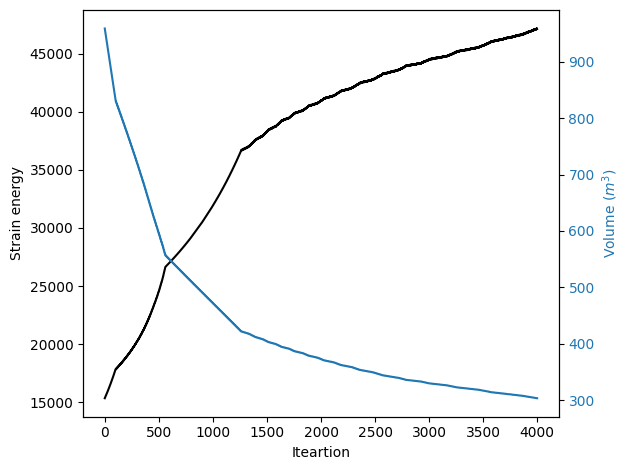

In [301]:
iteration = np.arange(0,len(W_list),1)


fig, ax1 = plt.subplots()

color = 'k'
ax1.set_xlabel('Iteartion')
ax1.set_ylabel('Strain energy',color=color)
ax1.plot(iteration, SE_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Volume ($m^3$)', color=color)  # we already handled the x-label with ax1
ax2.plot(iteration, W_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

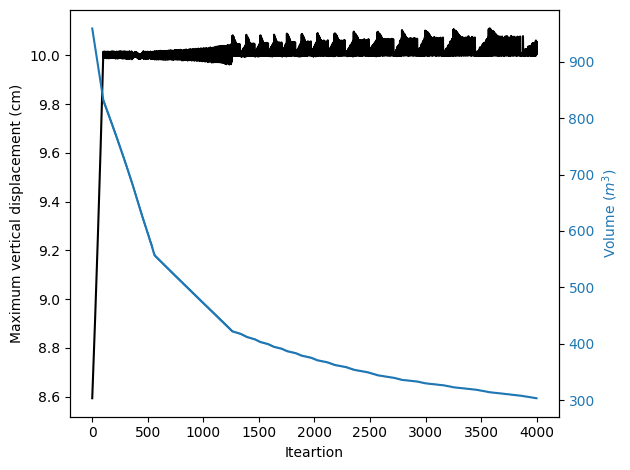

In [302]:
iteration = np.arange(0,len(W_list),1)


fig, ax1 = plt.subplots()

color = 'k'
ax1.set_xlabel('Iteartion')
ax1.set_ylabel('Maximum vertical displacement (cm)',color=color)
ax1.plot(iteration, 100*np.array(u_max_list), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Volume ($m^3$)', color=color)  # we already handled the x-label with ax1
ax2.plot(iteration, W_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Plot

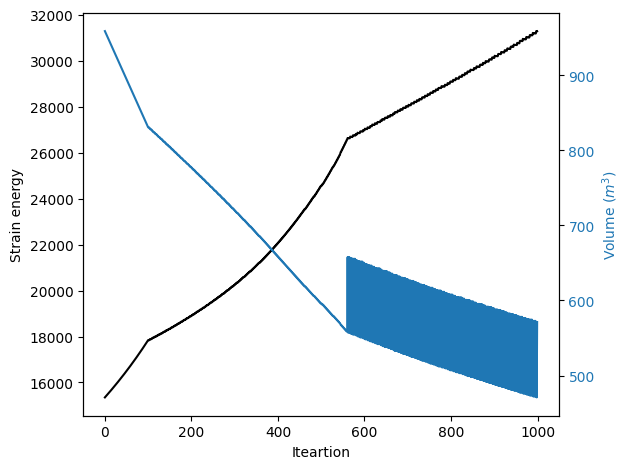

In [200]:
iteration = np.arange(0,len(W_list),1)


fig, ax1 = plt.subplots()

color = 'k'
ax1.set_xlabel('Iteartion')
ax1.set_ylabel('Strain energy',color=color)
ax1.plot(iteration, SE_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Volume ($m^3$)', color=color)  # we already handled the x-label with ax1
ax2.plot(iteration, W_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

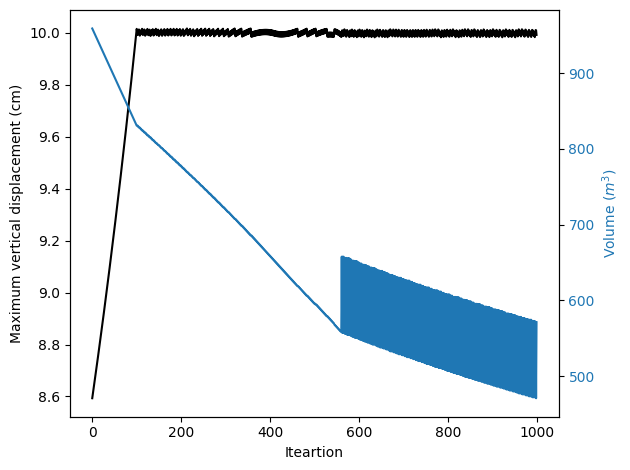

In [201]:
iteration = np.arange(0,len(W_list),1)


fig, ax1 = plt.subplots()

color = 'k'
ax1.set_xlabel('Iteartion')
ax1.set_ylabel('Maximum vertical displacement (cm)',color=color)
ax1.plot(iteration, 100*np.array(u_max_list), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'Volume ($m^3$)', color=color)  # we already handled the x-label with ax1
ax2.plot(iteration, W_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [303]:
from matplotlib.collections import LineCollection

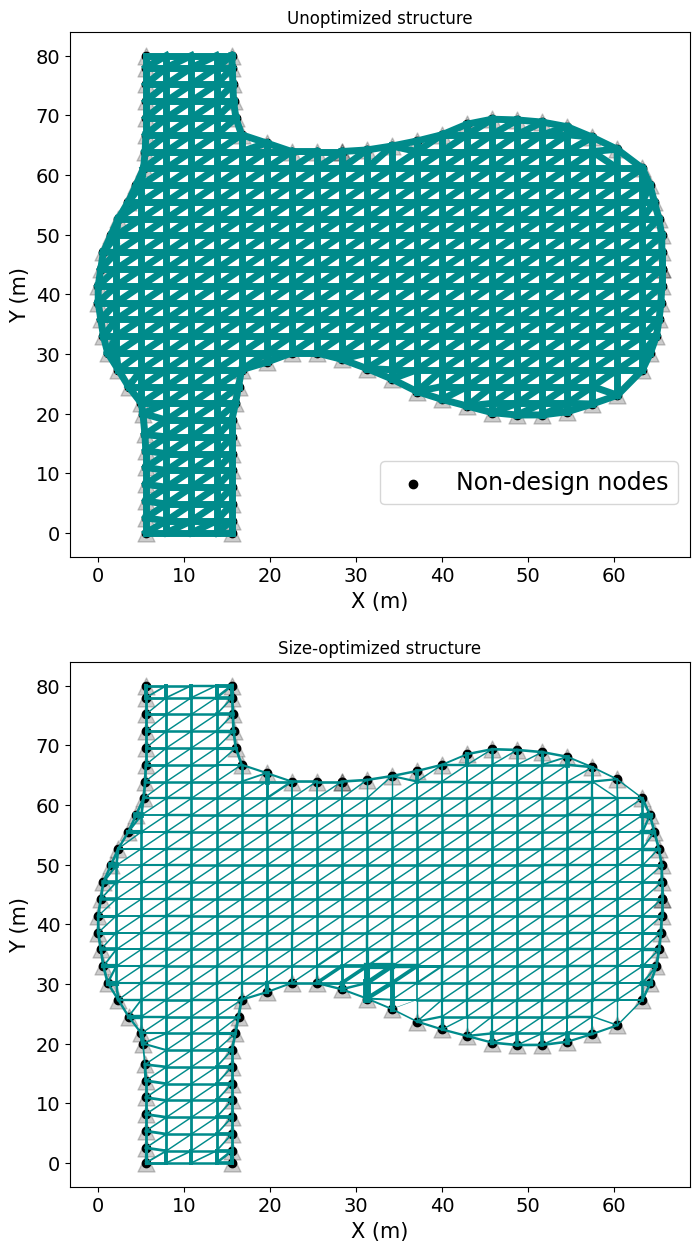

In [304]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8, 15))

ax1.set_title('Unoptimized structure')
ax1.set_xlabel('X (m)',fontsize=15)
ax1.set_ylabel('Y (m)',fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax1.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan',linewidth=5.0)

ax1.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax1.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')

ax1.legend(fontsize=17, loc=(0.5,0.1))

ax2.set_title('Size-optimized structure')
ax2.set_xlabel('X (m)',fontsize=15)
ax2.set_ylabel('Y (m)',fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
    lw=5.0 * A_opt[i]/A
    ax2.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan',linewidth=lw)

ax2.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax2.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')

ax1.legend(fontsize=17, loc=(0.5,0.1))
plt.show()

In [305]:
#Setup colormap
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(0, np.max(A_opt))

segs = []
colors = []
for i in range(n_ele):
    line = [(x_ele[i,0],y_ele[i,0]),(x_ele[i,1],y_ele[i,1])]
    segs.append(line)
    colors.append(cmap(norm(A)))

LC = LineCollection(segs,color=colors,linewidths=5.0)

In [306]:
segs = []
colors = []
lws = []
for i in range(n_ele):
    lw=5.0 * A_opt[i]/A
    line_colors = cmap(norm(A_opt[i]))
    line = [(x_ele[i,0],y_ele[i,0]),(x_ele[i,1],y_ele[i,1])]
    segs.append(line)
    colors.append(line_colors)
    lws.append(lw)

LC2 = LineCollection(segs,color=colors,linewidths=lws)

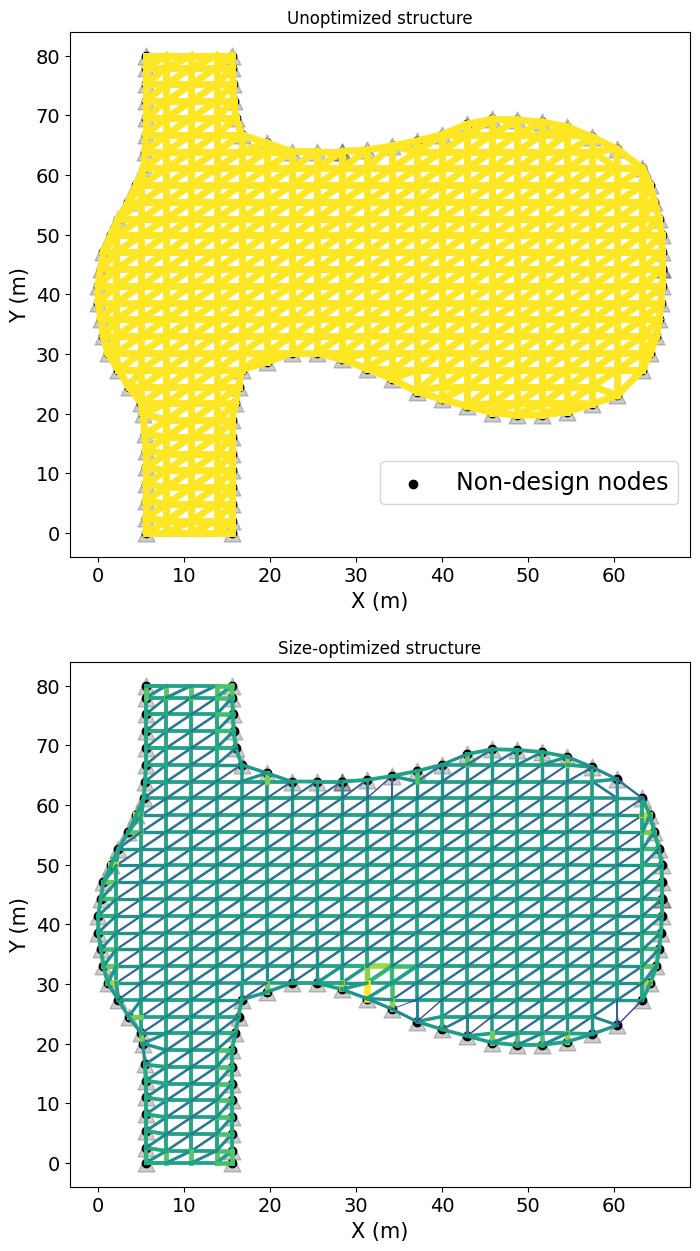

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(8, 15))




ax1.set_title('Unoptimized structure')
ax1.set_xlabel('X (m)',fontsize=15)
ax1.set_ylabel('Y (m)',fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
    line_colors = cmap(norm(A))
    ax1.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color=line_colors,linewidth=5.0)

ax1.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax1.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')

ax1.legend(fontsize=17, loc=(0.5,0.1))


ax2.set_title('Size-optimized structure')
ax2.set_xlabel('X (m)',fontsize=15)
ax2.set_ylabel('Y (m)',fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
    lw=5.0 * A_opt[i]/A
    line_colors = cmap(norm(A_opt[i]))
    ax2.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color=line_colors,linewidth=lw)

ax2.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax2.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')

ax1.legend(fontsize=17, loc=(0.5,0.1))
plt.show()